# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
%matplotlib inline

#importing some useful packages
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from collections import deque
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


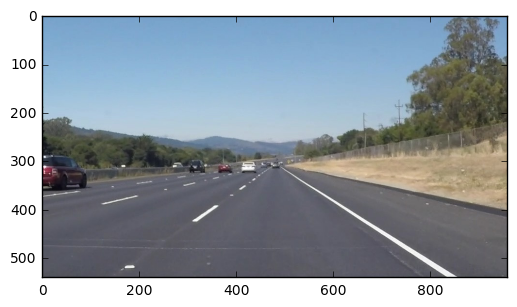

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

# Helps detecting lane lines preserving context based on last 5 frames.
class FrameSequenceLaneDetector:
    
    def __init__(self, frame_size):
        self.frame_size = frame_size         # Size of the frame, e.g. shape of a sample image.
        self.left_lines = deque(maxlen = 5)  # Last 5 detected left lines.
        self.right_lines = deque(maxlen = 5) # Last 5 detected right lines.
        self.gaussian_kernel = 5             # Gaussian kernel radius
        self.canny_low_threshold = 50        # Canny filter low theshold
        self.canny_high_threshold = 150      # Canny filter high theshold
        self.region = np.array(
                [
                    [ 
                        (0, frame_size[0]), 
                        (frame_size[1] * 0.47, frame_size[0] * 0.6), 
                        (frame_size[1] * 0.53, frame_size[0] * 0.6),
                        (frame_size[1], frame_size[0])
                    ]
                ], dtype=np.int32)           # Region of interest
        self.hough_rho = 2                   # Distance resolution in pixels of the Hough grid
        self.hough_theta = np.pi/180         # Angular resolution in radians of the Hough grid
        self.hough_threshold = 15            # Minimum number of votes (intersections in Hough grid cell)
        self.hough_min_line_length = 30      # Minimum number of pixels making up a line
        self.hough_max_line_gap = 20         # Maximum gap in pixels between connectable line segments
        self.slope_m = 0.65                  # Median value for allowed line slope
        self.slope_d = 0.25                  # Deviation of the slope value
    
    def process_frame(self, frame):
        """
        Processes a single frame and draws detected lines on top of the provided image.     
        """
        return self.weighted_img(self.lane_lines_mask(frame), frame)        
    
    def lane_lines_mask(self, image):
        """
        Applies a pipeline of transforms to the `image`. 
        Returns an image mask, e.g. black background with lines drawn.     
        """
        image = self.grayscale(image)
        image = self.gaussian_blur(image)
        image = self.canny(image)
        image = self.region_of_interest(image)
        image = self.hough_lines(image)
        return image
    
    def grayscale(self, img):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        you should call plt.imshow(gray, cmap='gray')"""
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def canny(self, img):
        """Applies the Canny transform"""
        return cv2.Canny(img, self.canny_low_threshold, self.canny_high_threshold)

    def gaussian_blur(self, img):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (self.gaussian_kernel, self.gaussian_kernel), 0)

    def region_of_interest(self, img):
        """Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `self.region`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, self.region, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def try_updating_detected_lines(self, lines):
        """
        Makes an attempt to detect valuable lines from `lines` and update saved lines.
        """
    
        def mean_line(lines, slopes, min_y, max_y, min_x, max_x): 
            """
            Returns a line based on mean values of `lines`. Expects `slopes` as well not to calculate them again.
            The top line's point will be bounded by `(min_x, min_y), (max_x, max_y)`. Bottom point does not have such restrictions.
            """
            xs = lines[:, :, (0, 2)].flatten() # All `x` values.
            ys = lines[:, :, (1, 3)].flatten() # All `y` values.

            # `k` and `b`, as in `y = kx + b`
            k = np.mean(slopes)
            b = np.mean(ys) - k * np.mean(xs)

            x1 = max( min( int((min_y - b) / k), max_x), min_x)
            y1 = k * x1 + b
            
            x2 = int((max_y - b) / k)
            y2 = max_y
            
            return [x1, y1, x2, y2]
        
        # First we check if we got any lines at all. There might be some weird frames!
        if lines is not None:        
            # Calculate slopes for each line.
            slope = lambda l: (l[3] - l[1]) / (l[2] - l[0])
            slopes = np.array([slope(line[0]) for line in lines])
            height = self.frame_size[0] # Frame height.
            width = self.frame_size[1] # Frame height.
            l_line = None # Detected left line.
            r_line = None # Detected right line.
            
            # Try to figure out the left line:
            # First filter all lines by removing those with inadequate slopes. We only expect a small range of slopes to be detected as left lines.
            fitting_lines = (slopes > - self.slope_m - self.slope_d) & (slopes < - self.slope_m + self.slope_d)
            # Only proceed if we are sure about the line, e.g. there are enough segments "voting" for it.
            # However it should also depend on if we already have some detected lines or not. 
            # The idea is: it's ok if we skip a frame or two in the middle of the video stream, as we might have enough previous data to "support" it.
            # But if we just started streaming we need to use all the info we've got, even if we are not fully sure it was correctly detected.
            if sum(fitting_lines) >= (len(self.left_lines) + 1):
                l_line = mean_line(lines[fitting_lines], slopes[fitting_lines], int(height * 0.6), height, 0, width * 0.45)                

            # Repeat the same process for the right line:
            fitting_lines = (slopes < self.slope_m + self.slope_d) & (slopes > self.slope_m - self.slope_d)
            if sum(fitting_lines) >= (len(self.right_lines) + 1):
                r_line = mean_line(lines[fitting_lines], slopes[fitting_lines], int(height * 0.6), height, width * 0.55, width)

            #  Only update the current stack of lines if we got something.
            if l_line is not None:
                self.left_lines.append(l_line)
            if r_line is not None:
                self.right_lines.append(r_line)
        
    def draw_lines(self, img, color=[255, 0, 0], thickness = 10):
        """
        Draws lane lines based on a mean of 5 last successful attempts to detect those. On a lucky day this would mean based on last 5 frames.
        The idea behind it is to smoothen the noize in detected lines across frames, trying to achieve the smoothness in `P1_example.mp4`. 
        """
        if self.left_lines:
            # Draw the left line:
            x1 = int(np.array(self.left_lines)[:, 0].mean())
            y1 = int(np.array(self.left_lines)[:, 1].mean())
            x2 = int(np.array(self.left_lines)[:, 2].mean())
            y2 = int(np.array(self.left_lines)[:, 3].mean())
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
        if self.right_lines:
            # Draw the right line:
            x1 = int(np.array(self.right_lines)[:, 0].mean())
            y1 = int(np.array(self.right_lines)[:, 1].mean())
            x2 = int(np.array(self.right_lines)[:, 2].mean())
            y2 = int(np.array(self.right_lines)[:, 3].mean())
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    def hough_lines(self, img):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(
            img, 
            self.hough_rho, 
            self.hough_theta, 
            self.hough_threshold, 
            np.array([]), 
            minLineLength = self.hough_min_line_length, 
            maxLineGap = self.hough_max_line_gap
        )
        self.try_updating_detected_lines(lines)
        line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
        self.draw_lines(line_img)
        return line_img

    # Python 3 has support for cool math symbols.

    def weighted_img(self, img, initial_img, α=0.8, β=1., λ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
def plot_sample(image, image_debug = None):
    """
    Plots a sample frame image, and an additional debug info frame side-by-side if latter is provided.
    `image` is a frame to plot.
    `image_debug` is a image containing useful debug info.        
    """
    print('Image dimensions:', image.shape)    
    fig = plt.figure(figsize = (10, 5))
    axis = fig.add_subplot(1, 2, 1)
    axis.imshow(image)
    
    if image_debug is not None:
        axis = fig.add_subplot(1, 2, 2)
        axis.imshow(image_debug, cmap='gray')
        
    plt.show()

File name: solidWhiteCurve.jpg
Image dimensions: (540, 960, 3)


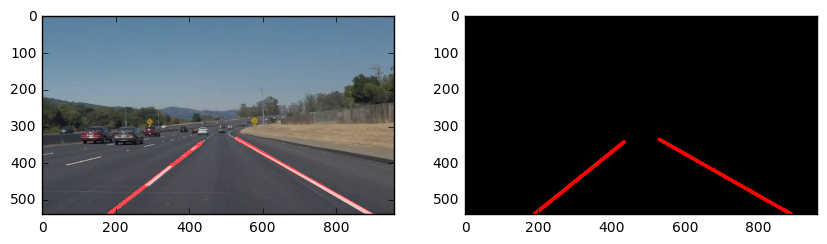

File name: solidWhiteRight.jpg
Image dimensions: (540, 960, 3)


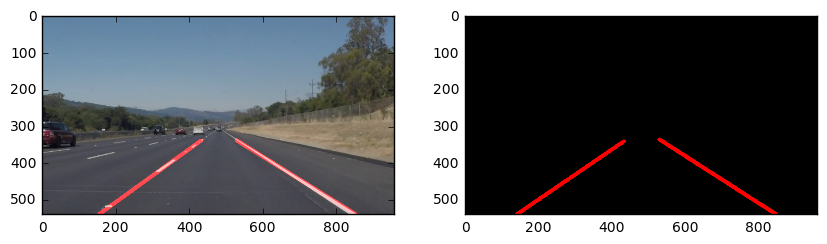

File name: solidYellowCurve.jpg
Image dimensions: (540, 960, 3)


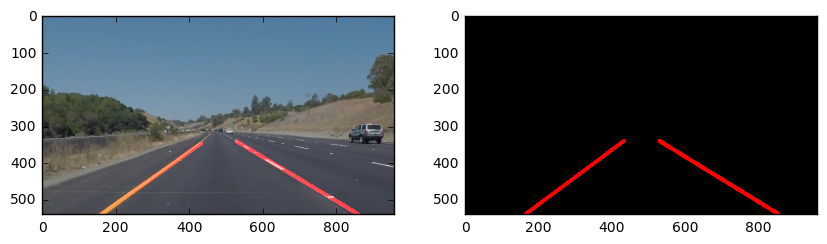

File name: solidYellowCurve2.jpg
Image dimensions: (540, 960, 3)


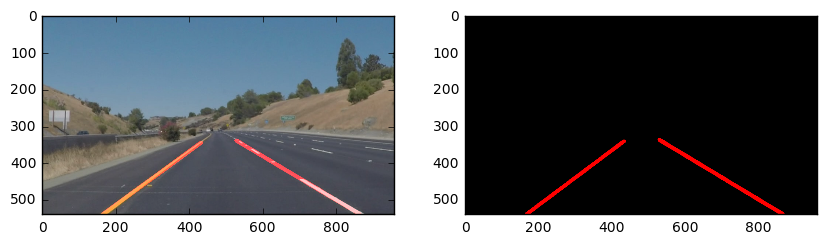

File name: solidYellowLeft.jpg
Image dimensions: (540, 960, 3)


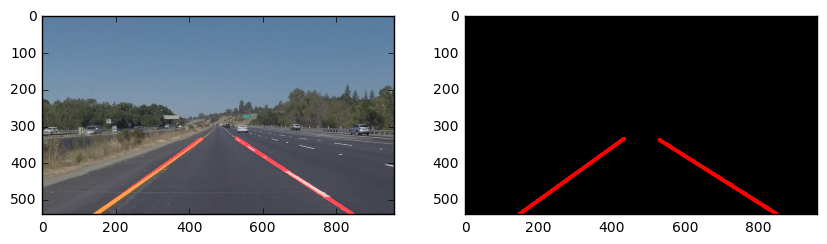

File name: whiteCarLaneSwitch.jpg
Image dimensions: (540, 960, 3)


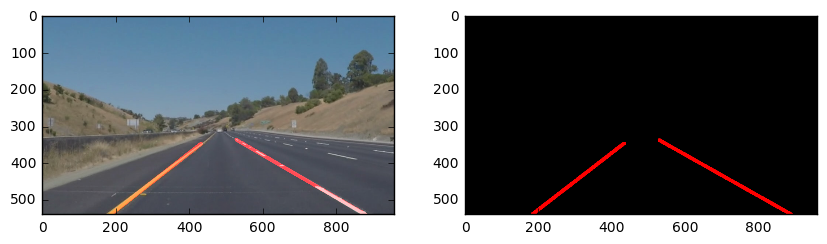

In [5]:
for image_name in sorted(os.listdir("test_images/")):
    if not image_name.startswith("annotated"):
        image = mpimg.imread("test_images/" + image_name)
        print("File name: " + image_name)
        image = FrameSequenceLaneDetector((540, 960, 3)).process_frame(image)
        mpimg.imsave("test_images/annotated_" + image_name, image)
        # Plot resulting image plus just the mask.
        plot_sample(image, image_debug = FrameSequenceLaneDetector((540, 960, 3)).lane_lines_mask(image))

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
detector = FrameSequenceLaneDetector((clip1.h, clip1.w, 3))
white_clip = clip1.fl_image(detector.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 46.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 11.8 s, sys: 56 ms, total: 11.8 s
Wall time: 5.13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
detector = FrameSequenceLaneDetector((clip2.h, clip2.w, 3))
yellow_clip = clip2.fl_image(detector.process_frame)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:15<00:00, 43.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 36.3 s, sys: 292 ms, total: 36.6 s
Wall time: 15.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Well it is going to fail in so many scenarios that I don't even know where to start. 
- Any road curvature, a turn or even change in weather is going to affect detecting capabilities significantly. 
- Roadsign shadows, road reflectors or any other means of traffic control are likely to interfere with lane selection process. 
- Going up/down the hill is going to screw the hardcoded region selection big time. 
- If the camera changes its tilt just a tiny bit it's going to break that region as well. 
— Not to mention other cars! They are going to drive the algorithm crazy, especially with a lot of traffic. Any lane obstruction is going to make it fail.

Overall hardcoding frame image region is a bad idea I reckon. Not to mention hardcoding allowed range of detected lines' slopes values. I'm actually surprised it works on the `challenge.mp4` video!

Ways to improve would include (but probably won't be limited to):
- Trying out the algorithm on a much bigger dataset. Most likely parameters I've used overfit those 3 videos I've used when implementing it.
- Getting more sensors data. A good example would be gyroscope data: if we have it we would be able to cater for some cases of camera misplacement and would be able to search for region of interest more accurately (rather than hardcoding it).
- Again, getting more sensors data. If we had access to steering wheel data we could predict change of expected lines' slopes, instead of hardcoding it.
- Have I mentioned more sensors data? If we could detect distance to other cars in traffic we could make assumptions on where lanes are even without getting any visual information — for instance in case of heavy traffic.
- I have a limited experience with deep learning, but I have a feeling that a carefully designed neural network could have been trained to detect lanes more accurately, especially if we provide features from Canny or even Hough transforms. 

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [9]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
detector = FrameSequenceLaneDetector((clip2.h, clip2.w, 3))
challenge_clip = clip2.fl_image(detector.process_frame)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:09<00:00, 27.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 17.2 s, sys: 364 ms, total: 17.6 s
Wall time: 9.9 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))